# HV Calibration

This notebook is a first attempt at performing calibration based on HV data. The calibration will be based on Matt's work [here (login required)](https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76#calibration_with_baseline_correction), rather than the previous, incorrect ladder calibration.

In [1]:
#Imports
import uproot, glob, math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline

In [2]:
datapath = "RQData/"
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]#["07220702_0911"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"] #["data"]

nser = len(ser); e=[]; z=[];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        #print(file)
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

#print(list(z[0])) #really just verifying that I imported something

#extra simplifying code if we have only one series
#z = z[0]
#e = e[0]

#print(z)

In [43]:
for x in z:
    x['crand'] = np.array([(y==1) for y in x['EventCategory']])
    x['PTwid'] = (x['PTWKf40'] - x['PTWKr40'])*1e6
    x['PTdbs'] = (x['PAbspost'] - x['PAbs'] + x['PBbspost'] - x['PBbs'] 
        + x['PCbspost'] - x['PCbs'] + x['PDbspost'] - x['PDbs'] + x['PEbspost'] - x['PEbs']
        + x['PFbspost'] - x['PFbs'])
    x['PTINTall_PTbscorr'] = x['PTINTall'] - ((x['PTdbs']<0)*0.5*x['PTdbs']*4096/x['PFnorm'])
    x['pt_keV'] = 7.738820e+07*x['PTOFamps']+1.653756e+13*x['PTOFamps']**2
    x['pt_keV_bscorr'] = x['pt_keV']/(1.-0.232*(x['PFbs']-3000.)/150) #baseline correction
    x['cam'] = x['PFOFamps']/x['PTOFamps']>0.21 #Americium cut
    x['xdel'] = 1e6*(x['PEWKr20'] - 0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel'] = 1e6*(0.866*(x['PDWKr20'] - x['PCWKr20']))+9
    x['phidel'] = [180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['cphi1'] = [(y>5) and (y < 20) for y in x['phidel']]

To get the aliases right, trying to reproduce: https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76#calibration_with_baseline_correction

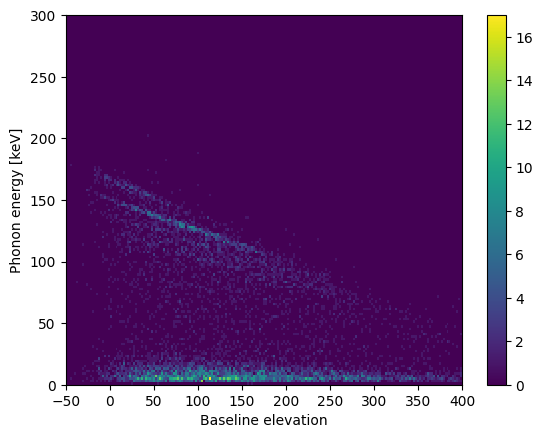

In [44]:
fig = plt.figure()
#Going to apply several data cuts in order to narrow down where we can fit to
h = plt.hist2d(z[4]["PFbs"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
plt.ylabel("Phonon energy [keV]")
plt.xlabel("Baseline elevation") #Not true yet; just the goal. 
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])
x = np.array([0,300])
#plt.plot(x,-0.232*x+150,color='r',linestyle='--')
#plt.plot([0,300],[150,75])

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

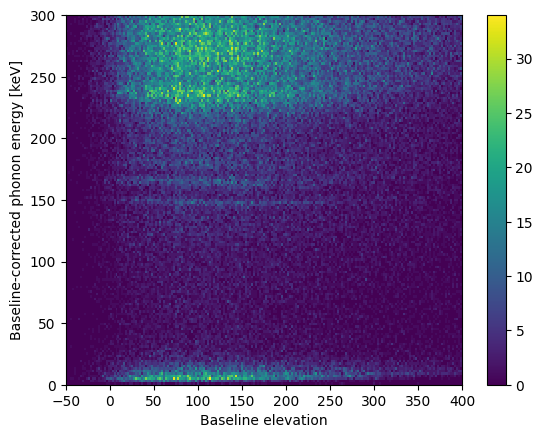

In [34]:
fig = plt.figure()
h = plt.hist2d(z[4]["PFbs"][~z[4]["crand"]]-3000,z[4]["pt_keV_bscorr"][~z[4]["crand"]]
               ,bins=[np.linspace(-50,400,200),np.linspace(0,300,150)])
plt.ylabel("Baseline-corrected phonon energy [keV]")
plt.xlabel("Baseline elevation") #Not true yet; just the goal. 
#Based on the calculation I think this might be what I have now? But,
#Based on the plot it's very clearly not it.
fig.colorbar(h[3])

comment = """
pointsx = [0,0.22e-6,0.29e-6,0.38e-6] #Measured outputs, not yet known.

plt.axhline(pointsx[1],color='red',linestyle='dotted')
plt.axhline(pointsx[2],color='red',linestyle='dotted')
plt.axhline(pointsx[3],color='red',linestyle='dotted')#"""

plt.show()

# An Automatic Fit

Below we will attempt to get this baseline correction automatically by fitting.

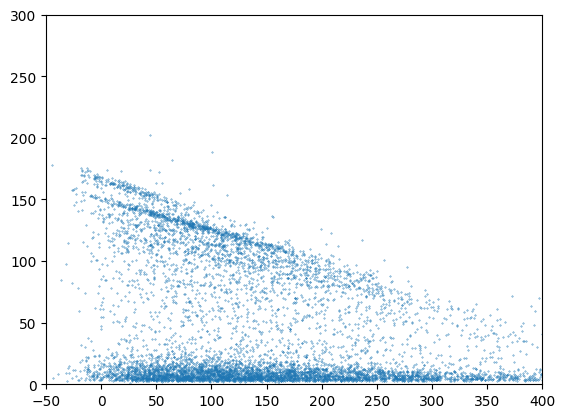

In [50]:
errors = np.sqrt(h[0]) #Get errors -- still sqrt(n)

def f(x,m=-0.232,b=150): #function for a line
    return m*x+b

#No reason I can't do this as a scatter plot, right? will be easier to fit if I treat it that way.
plt.scatter(z[4]["PFbs"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]]-3000,z[4]["pt_keV"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]],s=0.1)
plt.xlim(-50,400)
plt.ylim(0,300)
plt.show()

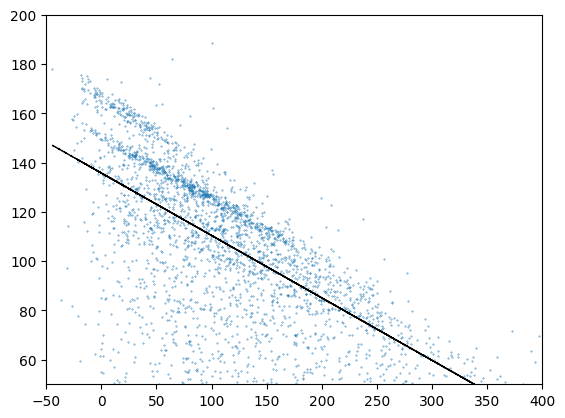

In [67]:
#Basic fit -- I expect issues with this due to many data points being the wrong region.

x = z[4]["PFbs"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]][z[4]["pt_keV"]>50]-3000
y = z[4]["pt_keV"][~z[4]["crand"]][z[4]["cphi1"]][z[4]["cam"]][z[4]["pt_keV"]>50] #cutting out all the "noise" at the bottom.

mod = lf.Model(f)
params = mod.make_params(m=-0.232,b=150)
fit = mod.fit(y,params,x=x)

plt.scatter(x,y,s=0.1)
plt.plot(x,fit.best_fit,linestyle='--',color='k',linewidth=1)
plt.xlim(-50,400)
plt.ylim(50,200)
plt.show()

fit